In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify
import random
from scipy import ndimage
import cv2
import platform
import pathlib
import json
import scipy.io

In [16]:
# Function to plot each individual cell mask as a series of subplots
def plot_all_cells_in_mask(all_cells_in_mask_1): 
    np.set_printoptions(threshold=np.inf)
    num_cells = len(all_cells_in_mask_1)

    # Create subplots: adjust the grid size as needed
    cols = int(np.ceil(np.sqrt(num_cells)))  # For a square-ish layout
    rows = int(np.ceil(num_cells / cols))
    _, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4))

    for i, cell_mask in enumerate(all_cells_in_mask_1):
        ax = axs.flat[i]
        ax.imshow(cell_mask[0], cmap='gray')
        ax.axis('off')  # Hide axis

    for i in range(num_cells, rows*cols):
        axs.flat[i].axis('off')

    plt.show()

# Func to get all cells' position and store them in a list of tuples(x,y)
def get_all_cells_pos(all_cells_in_mask_1):
    all_cell_positions = []

    for cell in all_cells_in_mask_1:
        cell_position = cell[1]
        y_pos, x_pos = cell_position[0][0], cell_position[0][1]
        all_cell_positions.append((y_pos, x_pos))

    return all_cell_positions

def patch_cells_into_picture_inc(all_cells_in_mask_1, all_cell_positions):
    picture = np.zeros((2048, 2048), dtype=int)
    
    for cell_mask, pos in zip(all_cells_in_mask_1, all_cell_positions):
        mask = cell_mask[0]  # Extract the mask (assuming it's at index 0)
        if np.all(mask == 0):  # Skip if the mask is all zeros
            continue
        
        y_pos, x_pos = pos  # Extract the y and x positions
        mask_height, mask_width = mask.shape
        binary_mask = mask > 0
        y_end, x_end = min(y_pos + mask_height, 2048), min(x_pos + mask_width, 2048)
        picture[y_pos:y_end, x_pos:x_end] |= binary_mask[:y_end-y_pos, :x_end-x_pos]
    
    return picture

# Func to patch individual cell mask into a whole picture
def patch_cells_into_picture_exc(all_cells_in_mask_1, all_cell_positions):
    picture = np.zeros((2048, 2048), dtype=int)
    
    for cell_mask, pos in zip(all_cells_in_mask_1, all_cell_positions):
        mask = cell_mask[0]  # Extract the mask (assuming it's at index 0)
        if np.all(mask == 0):  # Skip if the mask is all zeros
            continue
        
        y_pos, x_pos = pos  # Extract the y and x positions
        mask_height, mask_width = mask.shape
        binary_mask = mask > 0
        y_end, x_end = min(y_pos + mask_height, 2048), min(x_pos + mask_width, 2048)
        picture[y_pos:y_end, x_pos:x_end] |= binary_mask[:y_end-y_pos, :x_end-x_pos]
    
    # Check if the picture is all zeros after processing all cells
    if np.all(picture == 0):
        return None  # Or any other indicator that signifies an empty picture
    
    return picture

# Func to load data from a .mat file and store it in a dictionary
def load_matlab_data(mat_file):
    file = pathlib.Path(mat_file)
    mat = scipy.io.loadmat(file)
    return mat

# Func to convert the frames into a list of dictionaries
def convert(all_frames):
    converted: list[dict] = []
    for i in range(all_frames.shape[0]):
        cur = dict()
        # use try catch to avoid error on edge cases
        try:
            for j in range(100):
                cur[j] = all_frames[i][0,0][j][0]
        except IndexError:
            pass
        converted.append(cur)
    return converted

# Func to get all the cells from a single frame and store them in a list of lists
def getCellsField(singleFrame, cellsInfoIndex=12):
    keys = list(singleFrame.keys())
    cell_data = None
    for i in range(len(keys)):
        buffer = singleFrame[keys[i]]
        if buffer.shape != () and buffer.shape[0] != 1:
            cell_data = buffer
    
    # Check if cell_data itself is directly accessible or if we need to iterate over it
    if not isinstance(cell_data, list) and not hasattr(cell_data, '__iter__'):
        # If cell_data is neither list nor iterable, it's not structured as expected
        return []

    cells = []
    for i in range(len(cell_data)):
        info = []
        try:
            # Attempt to access nested structure if it exists
            # Adjust access pattern based on your data's structure
            cell = cell_data[i][0,0] if hasattr(cell_data[i], 'size') and cell_data[i].size > 0 else None
            if cell is None:
                continue  # Skip if cell is None or doesn't have the expected structure
            
            for j in range(min(cellsInfoIndex, len(cell))):
                info.append(cell[j])
        except (TypeError, IndexError) as e:
            # Handle cases where cell_data[i] does not support indexing or is out of bounds
            continue
        
        if info:  # Only append if info is not empty
            cells.append(info)
    
    return cells

def show_mat_data(mat, cols, dir_name):
    mat = load_matlab_data(mat)
    all_frames = mat[dir_name][0] # all the masks corresponding to 101 tifs
    all_frames_converted = convert(all_frames)
    all_masks = []
    mask_index = []
    for i in range(len(all_frames_converted)):
        mask = all_frames_converted[i]
        all_cells_in_mask = getCellsField(mask)
        all_cell_positions = get_all_cells_pos(all_cells_in_mask)
        picture = patch_cells_into_picture_exc(all_cells_in_mask, all_cell_positions)   
        all_masks.append(picture) if picture is not None else None
        mask_index.append(i + 1) if picture is not None else None

    plot_all(all_masks, cols, mask_index)

# Func to plot all the masks or pictures in a list
def plot_all(all, cols, mask_name):
    # Determine the number of masks
    num_masks = len(all)

    # Define the number of columns for subplots
    rows = num_masks // cols + (num_masks % cols > 0)

    # Create a figure to hold the subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))  # Adjust figsize as needed

    # Flatten the axes array for easy indexing if it's 2D (when rows > 1)
    if num_masks > 1:
        axs = axs.flatten()

    for i in range(num_masks):
        # Plot each mask
        ax = axs[i] if num_masks > 1 else axs
        ax.imshow(all[i], cmap='gray')
        ax.axis('off')  # Hide axis
        ax.set_title(f'Mask {mask_name[i]}')

    # Hide any unused subplots
    if num_masks > 1:
        for j in range(i+1, rows*cols):
            axs[j].axis('off')

    plt.tight_layout()
    plt.show()

# Func to plot A mask on A tif image
def plot_mask_on_image(image, mask):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='gray')
    plt.imshow(mask, cmap='jet', alpha=0.5)
    plt.title('Overlay of Image and Mask')
    plt.show()

# Func to plot ALL the masks on ALL images
def plot_all_masks_on_all_images(all_images, all_masks, cols, mask_index):
    # Determine the number of images
    num_images = len(all_images)

    # Define the number of columns for subplots
    rows = num_images // cols + (num_images % cols > 0)

    # Create a figure to hold the subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*5))  # Adjust figsize as needed

    # Flatten the axes array for easy indexing if it's 2D (when rows > 1)
    if num_images > 1:
        axs = axs.flatten()

    for i in range(num_images):
        # Plot each mask
        ax = axs[i] if num_images > 1 else axs
        ax.imshow(all_images[i], cmap='gray')
        ax.imshow(all_masks[i], cmap='jet', alpha=0.5)
        ax.axis('off')  # Hide axis
        ax.set_title(f'Mask {mask_index[i]}')

    # Hide any unused subplots
    if num_images > 1:
        for j in range(i+1, rows*cols):
            axs[j].axis('off')

    plt.tight_layout()
    plt.show()

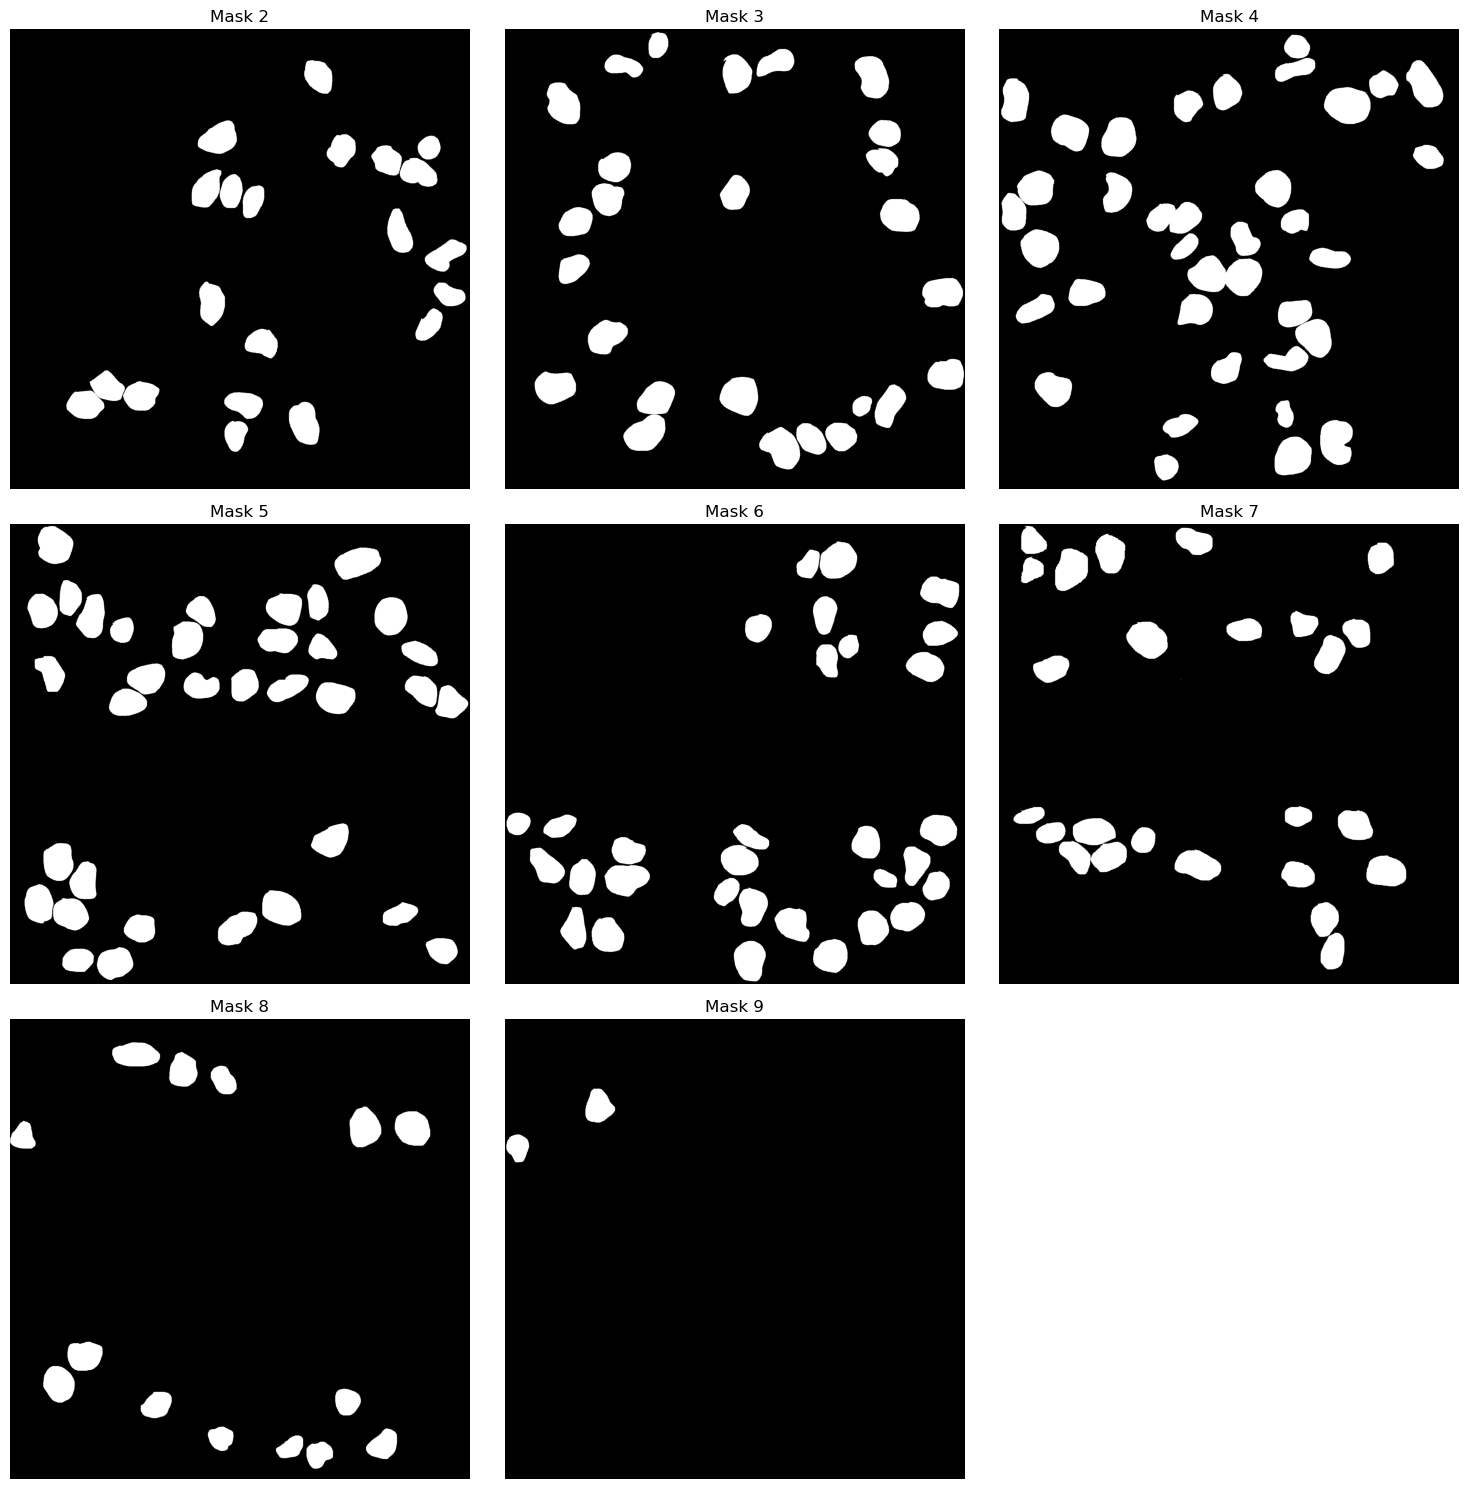

In [17]:
show_mat_data('Tracked_CTL1.mat', 3, 'Tracked_CTL1')


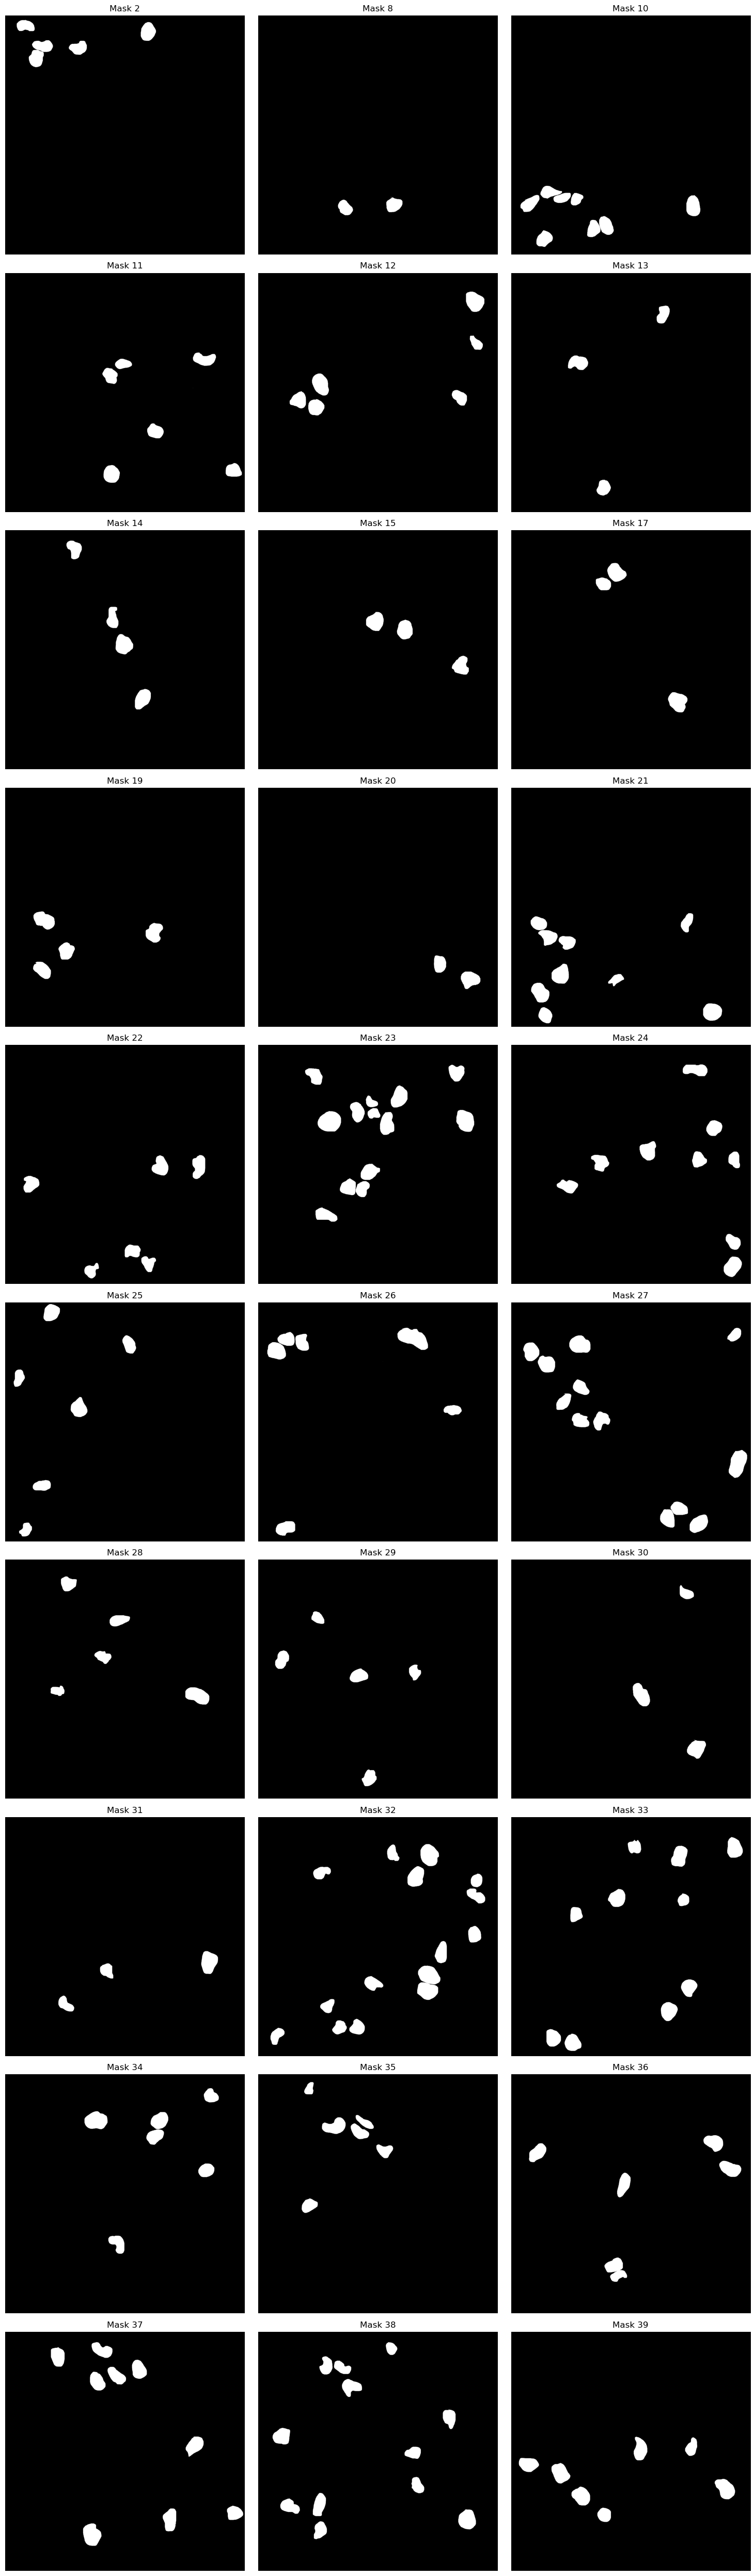

In [18]:
show_mat_data('Tracked_KO1.mat', 3, 'Tracked_KO1')